In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z
from imp import reload
import vice_utils

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.weight": "light",
    'text.latex.preamble' : r'\usepackage{siunitx,amsmath,helvet,sansmath}\sisetup{detect-all}\sansmath',
    "figure.dpi": 100,
    "date.autoformatter.minute": "%m/%d %H:%M"
})

In [4]:
print(vice.yields.sneia.fractional('c'))
print(vice.yields.agb.settings('c'))

5.7420404800000006e-06
cristallo11


In [6]:
def plot_c_table(study = "cristallo11"):
    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]

        plt.plot(m1, y, label=f"Z = {z}", c=cmap(i/N))

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    plt.legend()
    plt.title(study)

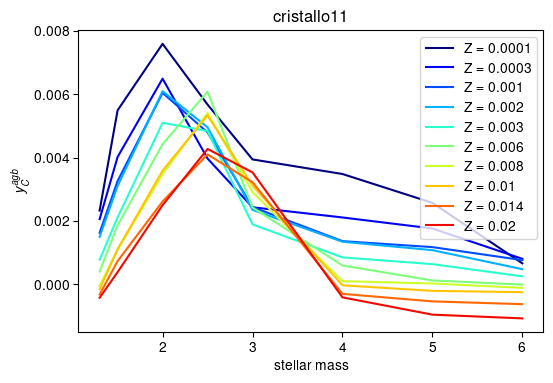

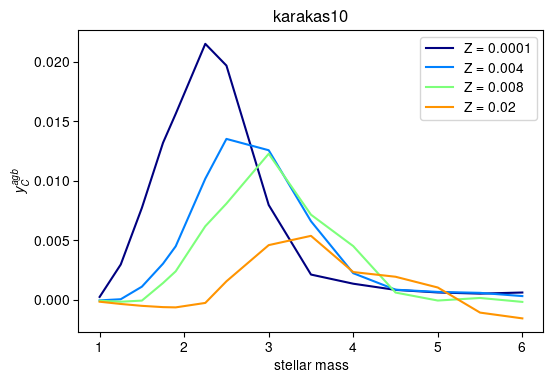

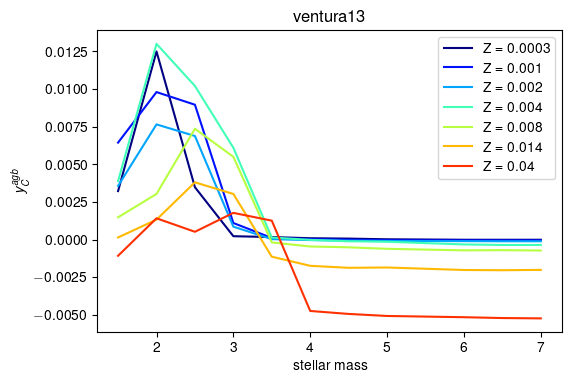

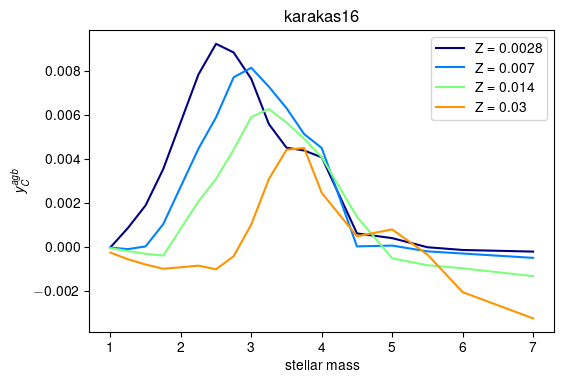

In [7]:
for study in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    plot_c_table(study)
    plt.show()

In [3]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    "CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

In [4]:
allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

ccsne_studies = ["LC18", "S16/N20", "CL13","CL04","WW95","NKT13"]
cmap = plt.get_cmap("jet")
N = len(ccsne_studies)

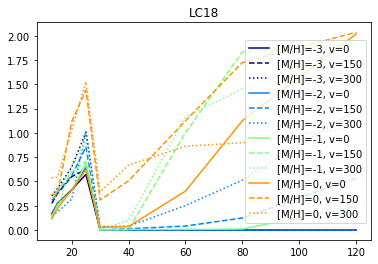

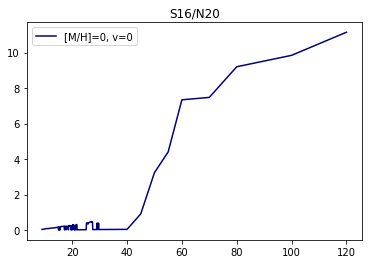

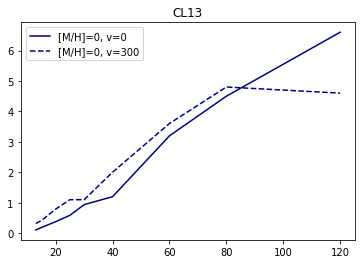

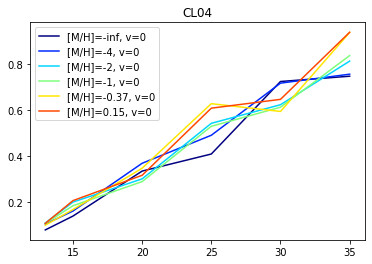

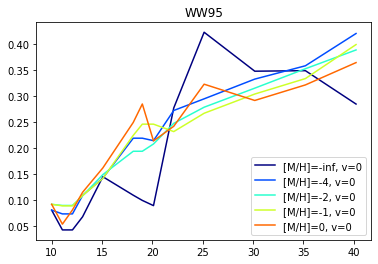

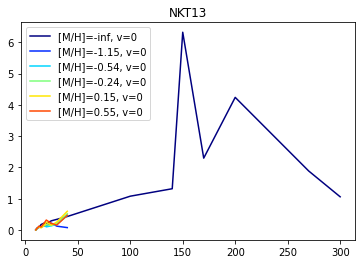

In [6]:
for study in ccsne_studies:
    metalicities = allowed_MoverH[study]
    
    N = len(metalicities)
    rotations = allowed_rotations[study]
    for i in range(N):
        for j in range(len(rotations)):
            rotation = rotations[j]
            MoverH = metalicities[i]
            table = vice.yields.ccsne.table("c", study=study, MoverH=MoverH, rotation=rotation)
            masses = table.masses
            yields = [table[mass] for mass in masses]

            plt.plot(masses, yields, label=f"[M/H]={MoverH}, v={rotation}", color=cmap(i/N), linestyle=["-", "--", ":"][j])
        
    plt.title(study)
    plt.legend()
    plt.show()

<ipython-input-7-c9376a8be92d>:8: ScienceWarning: Supernovae yields from the Chieffi & Limongi (2004), ApJ, 608, 405 study are sampled on a grid of stellar masses up to 35 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-7-c9376a8be92d>:8: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-7-c9376a8be92d>:8: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional

Text(0, 0.5, 'fractional yield')

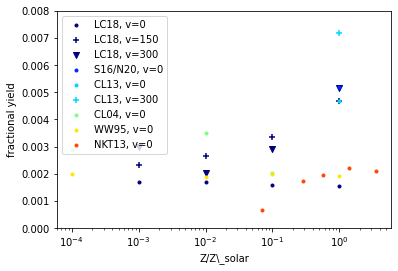

In [7]:
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        plt.scatter(Z, y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=[".", "+", "v"][j])

plt.legend()

plt.xscale("log")
plt.ylim([0, 0.008])
plt.xlabel("Z/Z\_solar")
plt.ylabel("fractional yield")

In [9]:
def load_model(name):
    milkyway = vice.output(name)
    milkyway.stars["abs_z"] = calculate_z(milkyway)
    milkyway.stars["R_origin"] = zone_to_R(np.array(milkyway.stars["zone_origin"]))
    milkyway.stars["R_final"] = zone_to_R(np.array(milkyway.stars["zone_final"]))
    return milkyway

In [67]:
models = {}
for name in ["cristallo11", "cristallo11_lateburst", "karakas10", "karakas10_lateburst", 
             "ventura13", "ventura13_lateburst", "karakas16", "karakas16_lateburst"]:
    models[name] = load_model(name)

In [68]:
max_zone = 155
stars = {}
for name, model in models.items():
    stars[name] = sample_stars(model.stars.filter("zone_origin", "<", max_zone), num=10_000)

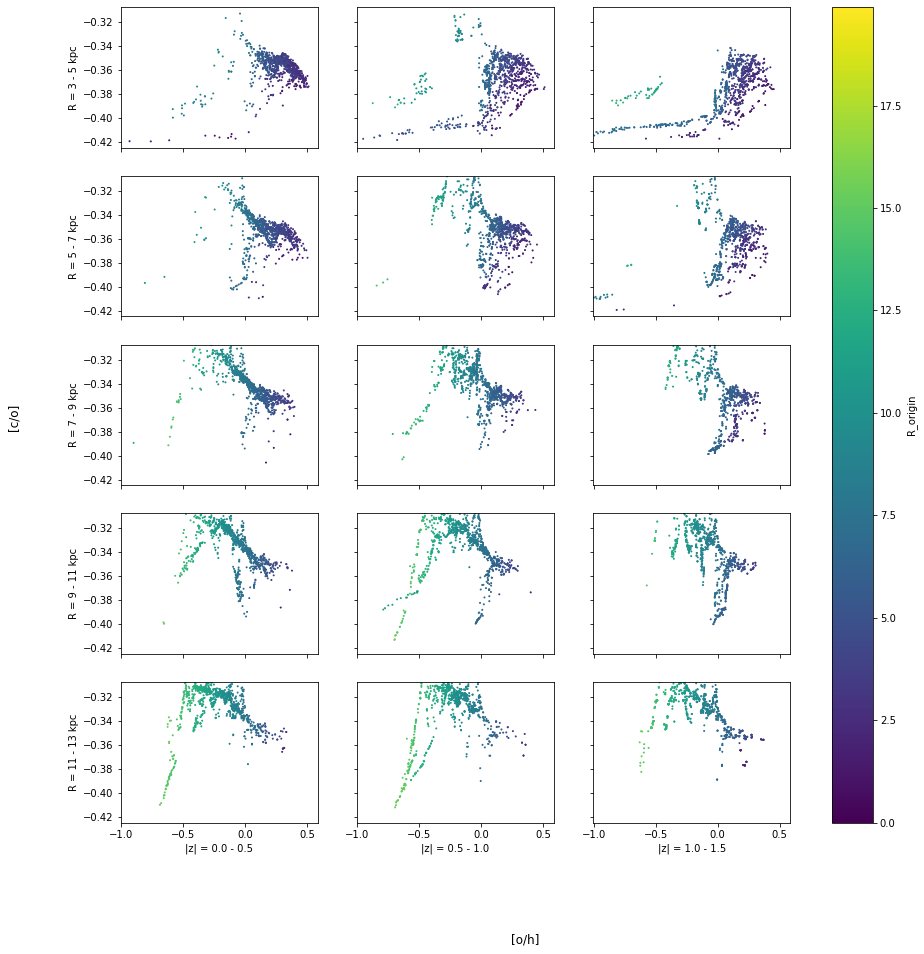

In [6]:
show_at_R_z(milkyway.stars, "[o/h]", "[c/o]", c="R_origin")

Text(0, 0.5, '[C/O]')

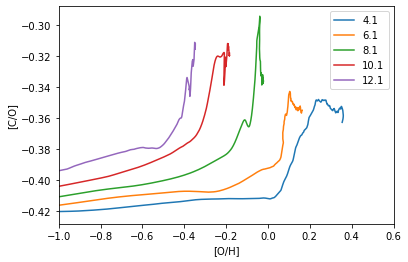

In [13]:
for i in R_to_zone(np.array([4, 6, 8, 10, 12])):
    x = milkyway.zones["zone%i" % i].history["[o/h]"]
    y = milkyway.zones["zone%i" % i].history["[c/o]"]
    plt.plot(x, y, label=i/10)
plt.legend()
plt.xlim(-1,0.6)
plt.xlabel("[O/H]")
plt.ylabel("[C/O]")

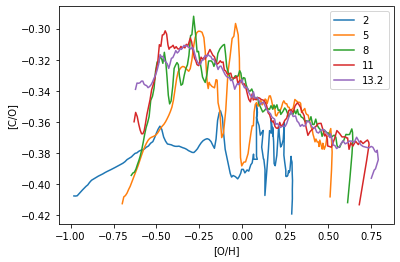

In [9]:
for t in [2, 5, 8, 11, 13.2]:
    j = int(100*t)
    
    y = np.zeros(155)
    x = np.zeros(155)
    R = np.arange(0, 15.5, 0.1)

    for i in range(155):
        y[i] = milkyway.zones["zone%i" % i].history["[c/o]"][j]
        x[i] = milkyway.zones["zone%i" % i].history["[o/h]"][j]
    plt.plot(x, y, label=t)


plt.xlabel("[O/H]")
plt.ylabel("[C/O]")
plt.legend()

Text(0, 0.5, '[c/o]')

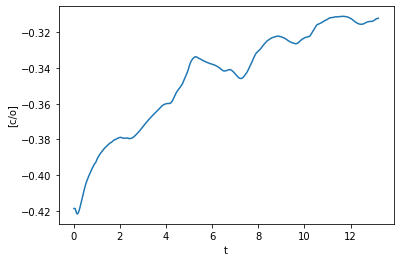

In [15]:
y = milkyway.zones["zone%i" % i].history["[c/o]"]
x = milkyway.zones["zone%i" % i].history["time"]
plt.plot(x, y)
plt.xlabel("t")
plt.ylabel("[c/o]")

In [55]:
def annulus_average(output, name, zone_min, zone_max):
    return np.average(np.array([output.zones["zone%i" % i].history[name] 
                                for i in range(zone_min, zone_max)]
                              ),
                      axis=0)

def show_annulus(output, x, y, c=None, R_min=7, R_max=9, **kwargs):
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = annulus_average(output, x, zone_min, zone_max)
    y_values = annulus_average(output, y, zone_min, zone_max)
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = annulus_average(output, c, zone_min, zone_max)
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)

In [27]:
x_l = [models["cristallo11"].zones["zone%i" % i].history["[fe/h]"] for i in range(70, 90)]

/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/daniel/.local/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


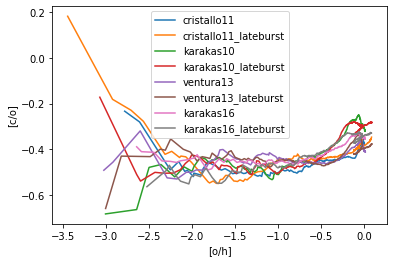

In [71]:
for name, model in models.items():
    show_annulus(model, "[o/h]", "[c/o]", label=name)
plt.legend()

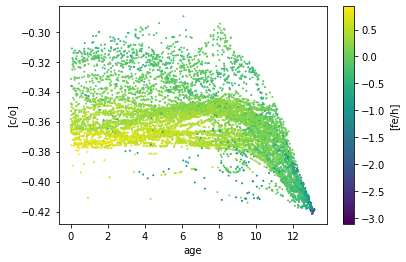

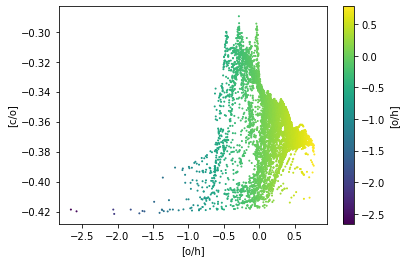

In [12]:
show_stars(stars, "age", "[c/o]", c="[fe/h]")
plt.show()
show_stars(stars, "[o/h]", "[c/o]", c="[o/h]")

In [59]:
def for_each_model(func, sfh="both"):
    names = ["cristallo11", "karakas10", "karakas16", "ventura13"]
    
    if sfh=="both":
        for name, model in models.items():
            func(model, name)
    elif sfh=="insideout":
        for name in names:
            func(models[name], name)
    else:
        for name in names:
            n = name + "_" + sfh
            func(models[n], n)

In [ ]:
for name, model in models.items():
    plt.figure(figsize=(8,4))
    show_stars(sample_stars(filter_stars(model.stars, 7, 9, 0, 0.5), 10**5), "age", "[c/o]", c="R_origin")
    plt.xscale("log")
    plt.xlim(0.3)
    plt.title(name)
    plt.show()

    show_stars(stars[name], "[o/h]", "[c/o]", c="R_origin")
    plt.title(name)

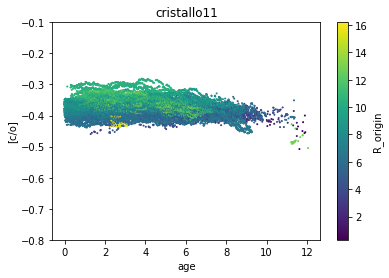

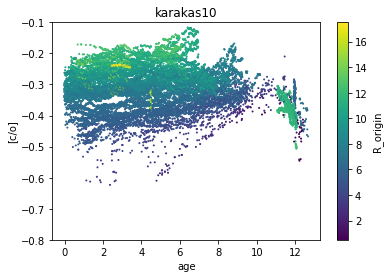

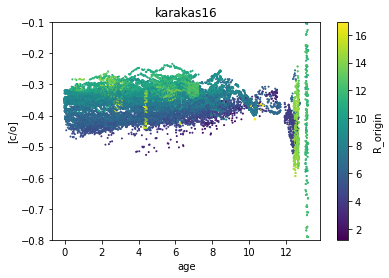

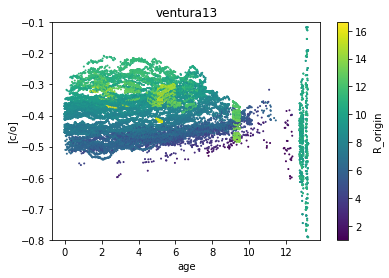

In [72]:
def plot_age_c_o(model, name):
    show_stars(filter_stars(model.stars, 7, 9, 0, 0.5), "age", "[c/o]", c="R_origin")
    plt.title(name)
    plt.ylim(-0.8, -0.1)
    plt.show()
    
for_each_model(plot_age_c_o, sfh="insideout")

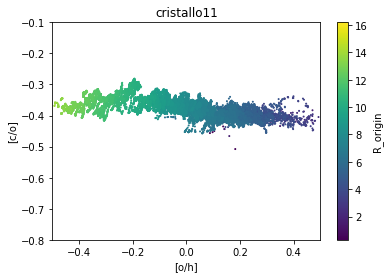

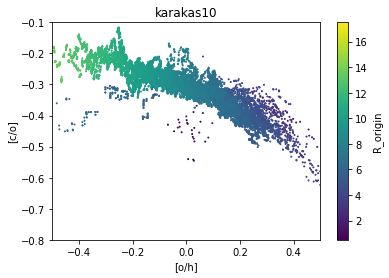

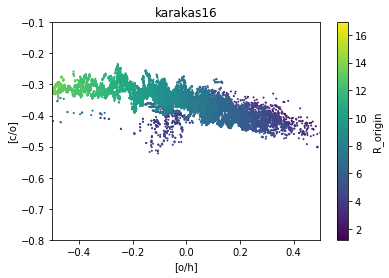

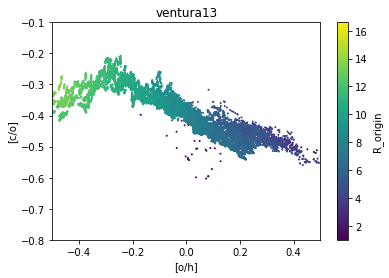

In [75]:
def plot_cooh(model, name):
    show_stars(filter_stars(model.stars, 7, 9, 0, 0.5), "[o/h]", "[c/o]", c="R_origin")
    plt.title(name)
    plt.ylim(-0.8, -0.1)
    plt.xlim(-0.5,0.5)
    plt.show()
    
for_each_model(plot_cooh, sfh="insideout")

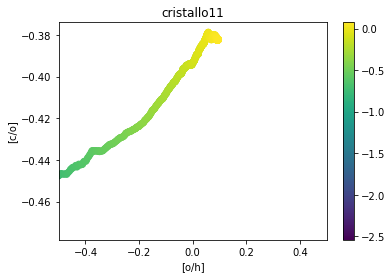

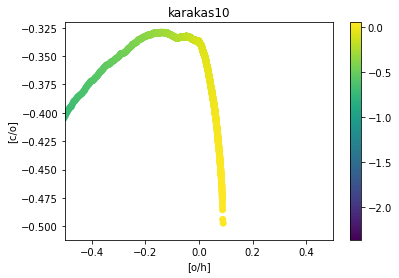

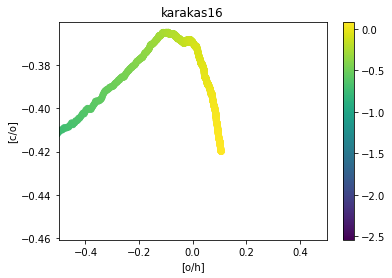

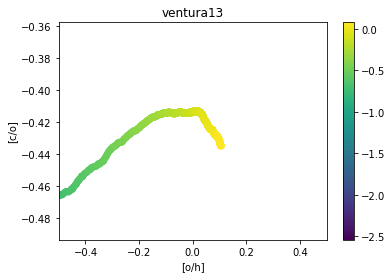

In [84]:
def c_o_annulus(model, name):
    show_annulus(model, "[o/h]", "[c/o]", c="[fe/h]", R_min=0, R_max=15)
    plt.title(name)
    plt.xlim(-0.5,0.5)
    plt.show()
    
for_each_model(c_o_annulus, sfh="insideout")